In [52]:
# Housing Prices - EDA Notebook

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import re
import numpy as np

# Load training and test data (dowanload the data and place it in data folder for each challenge)
train_df = pd.read_csv("../data/train.csv")
test_df = pd.read_csv("../data/test.csv")

# Display basic structure
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

#Lets print the data to see how it looks 
columns = train_df.columns
print(columns)
train_df.head()

# with open("../data/data_description.txt", "r") as f:
#     for line in f:
#         print(line.strip())





Train shape: (1460, 81)
Test shape: (1459, 80)
Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea',

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [54]:
test_df.loc[1089]

Id                  2550
MSSubClass            20
MSZoning              RL
LotFrontage        128.0
LotArea            39290
                  ...   
MiscVal            17000
MoSold                10
YrSold              2007
SaleType             New
SaleCondition    Partial
Name: 1089, Length: 80, dtype: object

In [ ]:
#Very quick Feature engineer function

def feature_eng_col(df, col):
    arr = df[col].unique()
    has_nan = pd.isna(arr).any()
    
    tail_col = ['LotFrontage', 'MiscVal', 'GrLivArea', '1stFlrSF', '2ndFlrSF', 
                 'GarageArea', 'OpenPorchSF', 'WoodDeckSF', 'BsmtUnfSF', 'BsmtFinSF1',
                   'MasVnrArea', 'LotArea', 'BsmtFinSF1', 'TotalBsmtSF', 'BsmtFinSF2']

    if has_nan:
        arr = arr[~pd.isna(arr)]
    
    # check if all unique values are numeric
    converted = pd.to_numeric(arr, errors="coerce")
    is_numeric = np.all(~np.isnan(converted))

    if is_numeric:
        # numeric column — fill NaN with mean
        # df[col] = df[col].fillna(df[col].mean()) ## Mean of gloabl data
        df[col] = df.groupby("Neighborhood")[col].transform(lambda x: x.fillna(x.median())) # Medain from closest neighbours 
        if col in tail_col:
            df[col] = df[col].apply(np.log1p)
    else:
        # categorical — map to codes
        n_feat = len(arr)
        hot_codes = list(range(1, n_feat + 1))
        res = {}
        for i, j in zip(arr, hot_codes):
            res.update({i: j})
        df[col] = df[col].map(res).fillna(0).astype(int)
    
    ### Add feature engineered properties to data set
    df['Qual_Living'] = df['OverallQual'] * df['GrLivArea']
    df['CarSpaceVal'] = df['GarageCars'] * df['GarageArea']
    df['FloorRatio'] = df['2ndFlrSF']/(df['1stFlrSF']+1) #Add 1 to make sure you dont dived by zero
    df['TotalFinishedBasementSF'] = df['BsmtFinSF1'] + df['BsmtFinSF2']
    df['TotalHouseSF'] = df['GrLivArea'] + df['TotalFinishedBasementSF'] 
    df['TotalBath'] = df['FullBath'] +df['HalfBath']*0.5 + df['BsmtFullBath']+ df['BsmtHalfBath']*0.5 
    df['TotalPorchSF'] = (
        df['OpenPorchSF']
        + df['EnclosedPorch']
        + df['3SsnPorch']
        + df['ScreenPorch']
        + df['WoodDeckSF']
    )
    df["Cond_Size"] = df["TotalHouseSF"] * df["OverallCond"]
    df["BathsPerBedroom"] = (
    (df["FullBath"] + 0.5 * df["HalfBath"] + df["BsmtFullBath"] + 0.5 * df["BsmtHalfBath"])
    / (df["BedroomAbvGr"] + 1)
)
    df["PorchQual"] = df["TotalPorchSF"] * df["OverallQual"]
    df["Age"] = df["YrSold"] - df["YearBuilt"]
    df["AgeSinceRemod"] = df["YrSold"] - df["YearRemodAdd"]
    df["Remod_Ratio"] = df["AgeSinceRemod"] / (df["Age"] + 1)
    df["Remod_Ratio"].replace([np.inf, -np.inf], np.nan, inplace=True)
    df["Remod_Ratio"].fillna(0, inplace=True)



    
    return df

for col in columns:
    if col != 'SalePrice':
        train_df = feature_eng_col(train_df, col)
        test_df = feature_eng_col(test_df, col)



train_df = train_df[train_df.SalePrice < 600_000]

train_df['log_SalePrice'] = np.log1p(train_df['SalePrice'])
# test_df['log_SalePrice'] = np.log1p(test_df['SalePrice'])

In [51]:
# np.where(np.isinf(test_df['Remod_Ratio'].values) == True)
test_df['Remod_Ratio'].loc[1089]

np.float64(-inf)

| Column Name   | Description                                                   |
|---------------|---------------------------------------------------------------|
| `Id`          | Unique identifier for each property                           |
| `MSSubClass`  | The type of dwelling involved in the sale                     |
| `MSZoning`    | General zoning classification of the sale                     |
| `LotFrontage` | Linear feet of street connected to property                   |
| `LotArea`     | Lot size in square feet                                       |
| `Street`      | Type of road access to the property                           |
| `Alley`       | Type of alley access to the property                          |
| `LotShape`    | General shape of the property                                 |
| `LandContour` | Flatness of the property                                      |
| `Utilities`   | Type of utilities available                                   |
| `LotConfig`   | Lot configuration                                             |
| `LandSlope`   | Slope of the property                                         |
| `Neighborhood`| Physical locations within Ames city limits                    |
| `Condition1`  | Proximity to various conditions                               |
| `Condition2`  | Proximity to various conditions (if more than one is present) |
| `BldgType`    | Type of dwelling                                              |
| `HouseStyle`  | Style of dwelling                                             |
| `OverallQual` | Overall material and finish quality                           |
| `OverallCond` | Overall condition rating                                      |
| `YearBuilt`   | Original construction year                                    |
| `YearRemodAdd`| Year of remodel or addition                                   |
| `RoofStyle`   | Type of roof                                                  |
| `RoofMatl`    | Roof material                                                 |
| `Exterior1st` | Exterior covering on the house                                |
| `Exterior2nd` | Exterior covering on the house (if more than one material)    |
| `MasVnrType`  | Masonry veneer type                                           |
| `MasVnrArea`  | Masonry veneer area in square feet                            |
| `ExterQual`   | Exterior material quality                                     |
| `ExterCond`   | Present condition of exterior material                        |
| `Foundation`  | Type of foundation                                            |
| `BsmtQual`    | Basement height                                               |
| `BsmtCond`    | General basement condition                                    |
| `BsmtExposure`| Walkout or garden level basement walls                        |
| `BsmtFinType1`| Rating of basement finished area                              |
| `BsmtFinSF1`  | Type 1 finished square feet                                   |
| `BsmtFinType2`| Rating of basement finished area (if multiple types)          |
| `BsmtFinSF2`  | Type 2 finished square feet                                   |
| `BsmtUnfSF`   | Unfinished square feet of basement area                       |
| `TotalBsmtSF` | Total square feet of basement area                            |
| `Heating`     | Type of heating                                               |
| `HeatingQC`   | Heating quality and condition                                 |
| `CentralAir`  | Central air conditioning                                      |
| `Electrical`  | Electrical system                                             |
| `1stFlrSF`    | First floor square feet                                       |
| `2ndFlrSF`    | Second floor square feet                                      |
| `LowQualFinSF`| Low quality finished square feet (all floors)                 |
| `GrLivArea`   | Above grade (ground) living area square feet                  |
| `BsmtFullBath`| Basement full bathrooms                                       |
| `BsmtHalfBath`| Basement half bathrooms                                       |
| `FullBath`    | Full bathrooms above grade                                    |
| `HalfBath`    | Half bathrooms above grade                                    |
| `BedroomAbvGr`| Number of bedrooms above basement level                       |
| `KitchenAbvGr`| Number of kitchens                                            |
| `KitchenQual` | Kitchen quality                                               |
| `TotRmsAbvGrd`| Total rooms above grade (does not include bathrooms)          |
| `Functional`  | Home functionality rating                                     |
| `Fireplaces`  | Number of fireplaces                                          |
| `FireplaceQu` | Fireplace quality                                             |
| `GarageType`  | Garage location                                               |
| `GarageYrBlt` | Year garage was built                                         |
| `GarageFinish`| Interior finish of the garage                                 |
| `GarageCars`  | Size of garage in car capacity                                |
| `GarageArea`  | Size of garage in square feet                                 |
| `GarageQual`  | Garage quality                                                |
| `GarageCond`  | Garage condition                                              |
| `PavedDrive`  | Paved driveway                                                |
| `WoodDeckSF`  | Wood deck area in square feet                                 |
| `OpenPorchSF` | Open porch area in square feet                                |
| `EnclosedPorch`| Enclosed porch area in square feet                           |
| `3SsnPorch`   | Three season porch area in square feet                        |
| `ScreenPorch` | Screen porch area in square feet                              |
| `PoolArea`    | Pool area in square feet                                      |
| `PoolQC`      | Pool quality                                                  |
| `Fence`       | Fence quality                                                 |
| `MiscFeature` | Miscellaneous feature not covered in other categories         |
| `MiscVal`     | Value of miscellaneous feature                                |
| `MoSold`      | Month Sold                                                    |
| `YrSold`      | Year Sold                                                     |
| `SaleType`    | Type of sale                                                  |
| `SaleCondition`| Condition of sale                                            |
| `SalePrice`   | Sale price of the house                                       |


In [82]:
# lets havea look how many NaN there are in each column
columns = train_df.columns
for col in columns:
    print('In {} there are {} NaNs'.format(col, train_df[col].isna().sum()))


In Id there are 0 NaNs
In MSSubClass there are 0 NaNs
In MSZoning there are 0 NaNs
In LotFrontage there are 0 NaNs
In LotArea there are 0 NaNs
In Street there are 0 NaNs
In Alley there are 0 NaNs
In LotShape there are 0 NaNs
In LandContour there are 0 NaNs
In Utilities there are 0 NaNs
In LotConfig there are 0 NaNs
In LandSlope there are 0 NaNs
In Neighborhood there are 0 NaNs
In Condition1 there are 0 NaNs
In Condition2 there are 0 NaNs
In BldgType there are 0 NaNs
In HouseStyle there are 0 NaNs
In OverallQual there are 0 NaNs
In OverallCond there are 0 NaNs
In YearBuilt there are 0 NaNs
In YearRemodAdd there are 0 NaNs
In RoofStyle there are 0 NaNs
In RoofMatl there are 0 NaNs
In Exterior1st there are 0 NaNs
In Exterior2nd there are 0 NaNs
In MasVnrType there are 0 NaNs
In MasVnrArea there are 0 NaNs
In ExterQual there are 0 NaNs
In ExterCond there are 0 NaNs
In Foundation there are 0 NaNs
In BsmtQual there are 0 NaNs
In BsmtCond there are 0 NaNs
In BsmtExposure there are 0 NaNs
In B

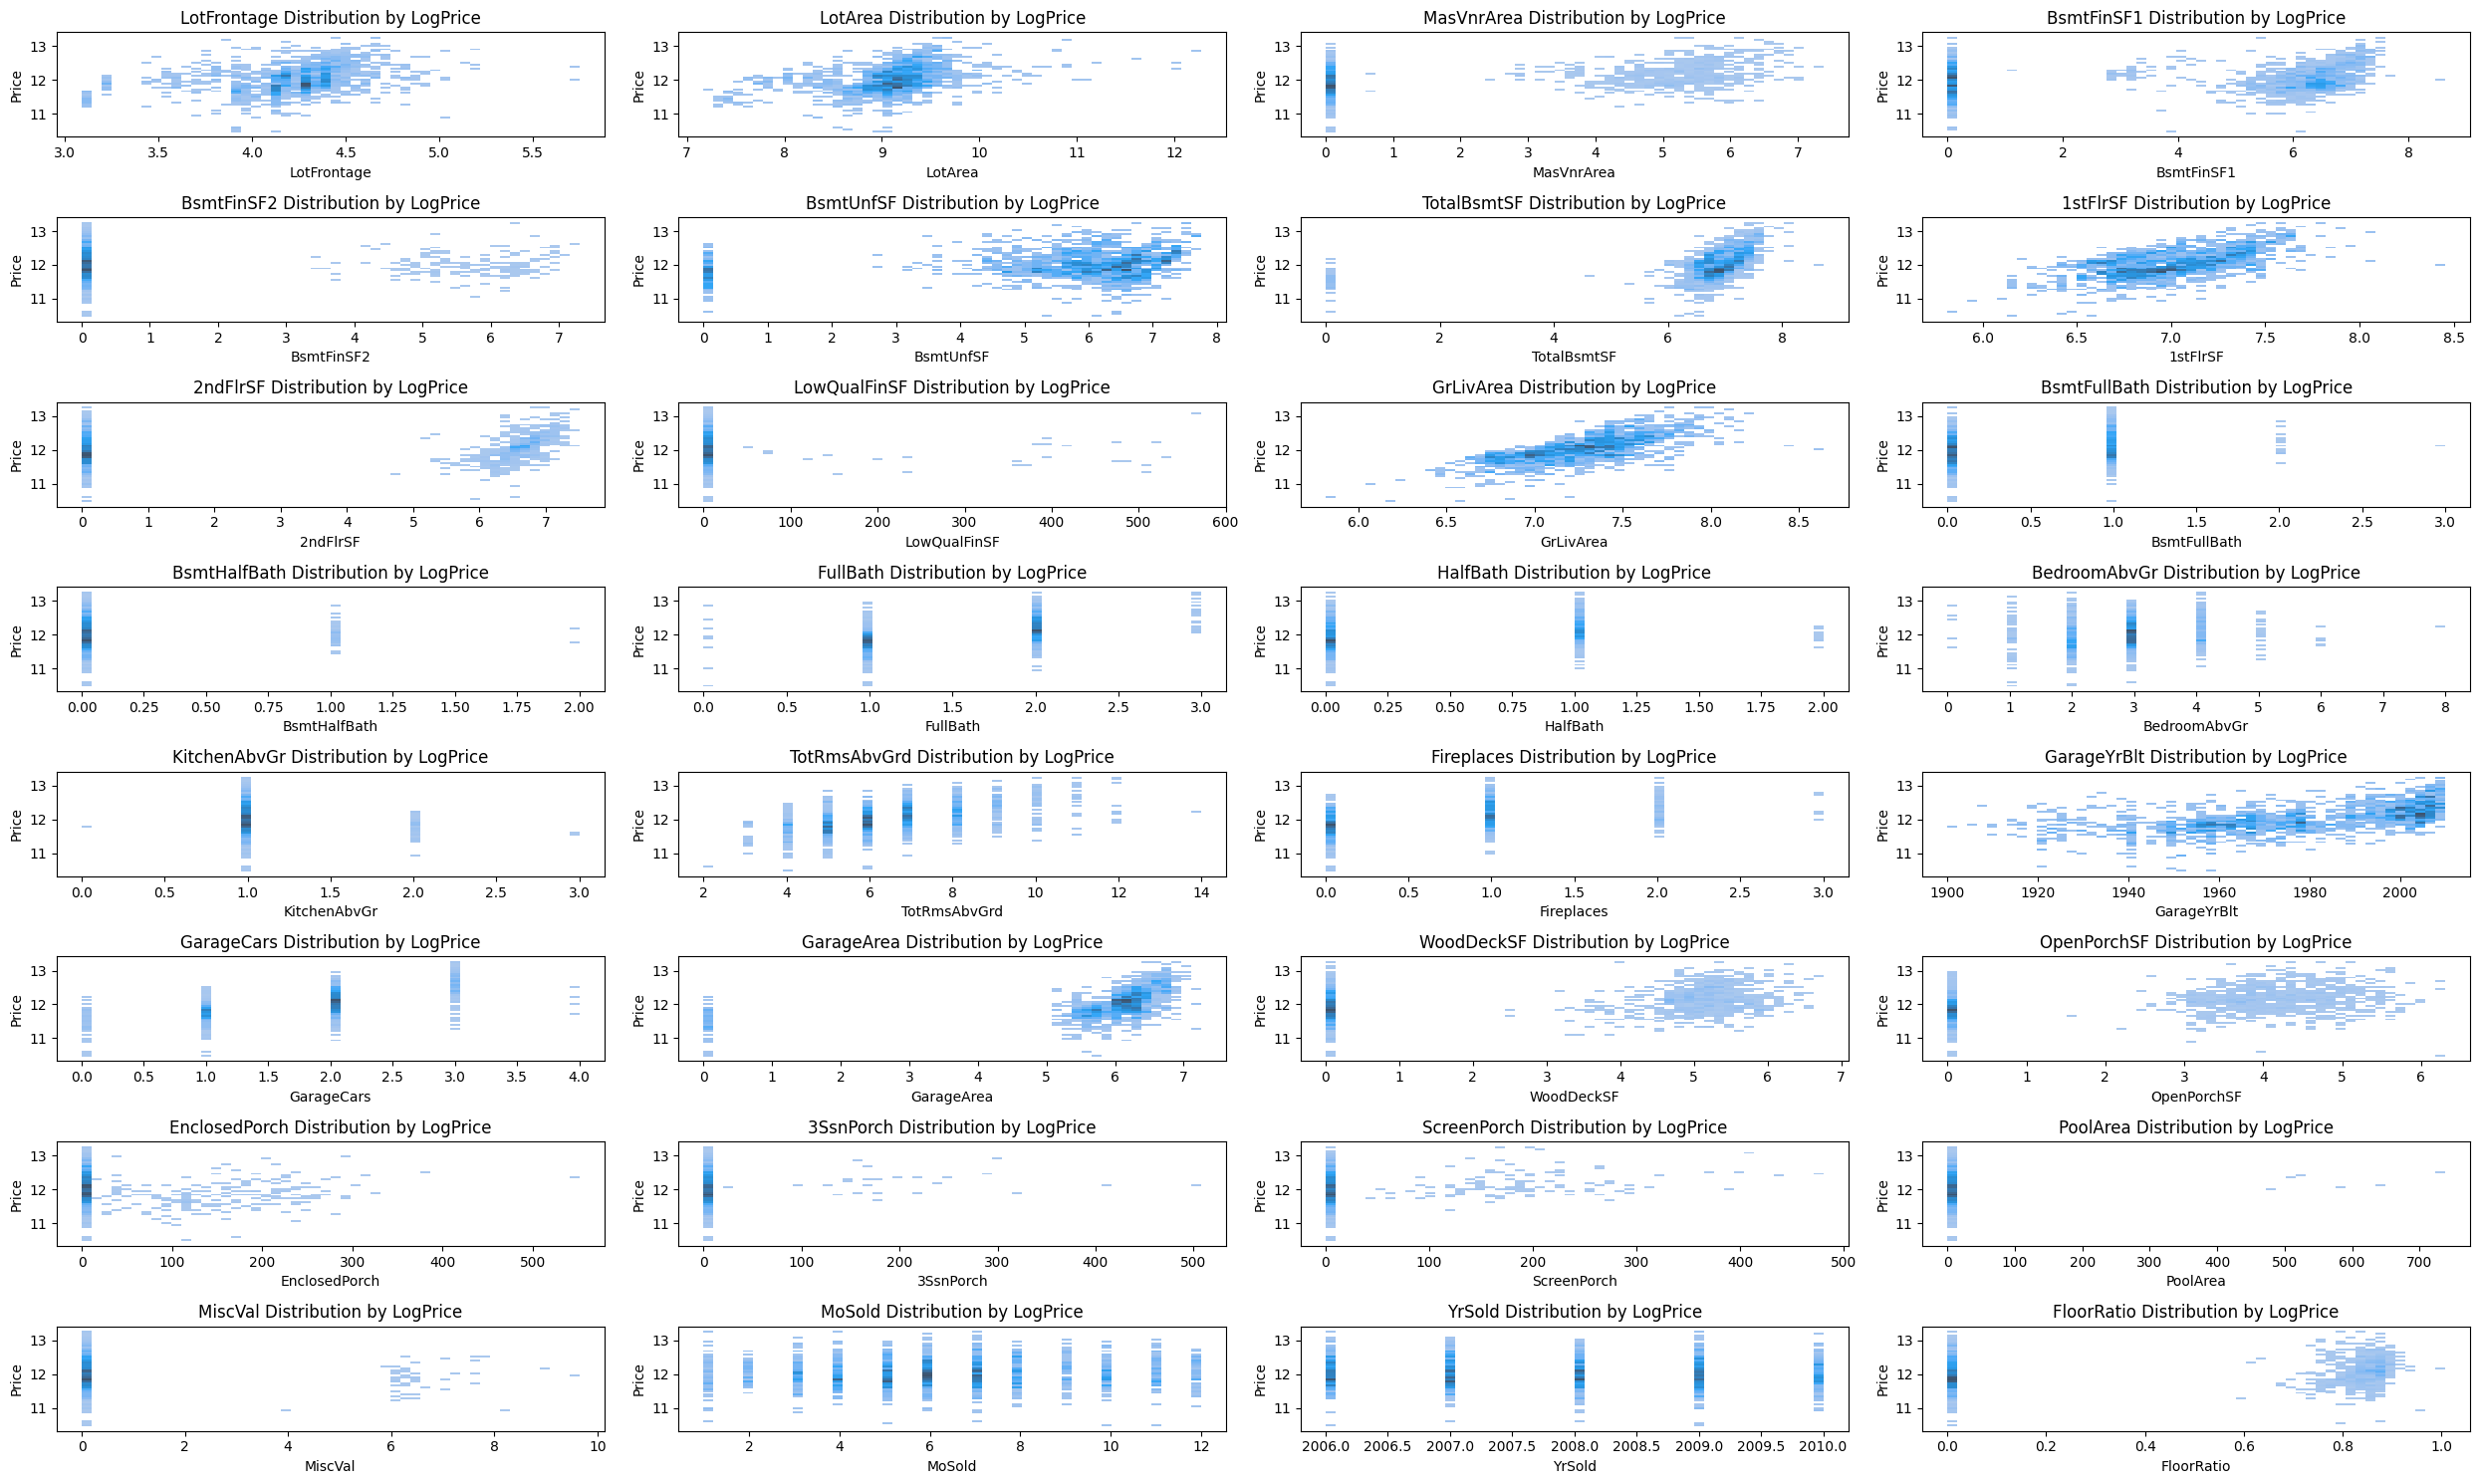

In [3]:
# lets make some histogram plots showing the hue of survival rate over differnt dimensions
fig, ax = plt.subplots(8, 4, figsize=(25, 15))
ax = ax.flatten()


# Pick 6 features you want to explore
columns = [
    "LotFrontage",
    "LotArea",
    "MasVnrArea",
    "BsmtFinSF1",
    "BsmtFinSF2",
    "BsmtUnfSF",
    "TotalBsmtSF",
    "1stFlrSF",
    "2ndFlrSF",
    "LowQualFinSF",
    "GrLivArea",
    "BsmtFullBath",
    "BsmtHalfBath",
    "FullBath",
    "HalfBath",
    "BedroomAbvGr",
    "KitchenAbvGr",
    "TotRmsAbvGrd",
    "Fireplaces",
    "GarageYrBlt",
    "GarageCars",
    "GarageArea",
    "WoodDeckSF",
    "OpenPorchSF",
    "EnclosedPorch",
    "3SsnPorch",
    "ScreenPorch",
    "PoolArea",
    "MiscVal",
    "MoSold",
    "YrSold",
    "FloorRatio"
]

for i, col in enumerate(columns):
    sns.histplot(data=train_df, x=col, y='log_SalePrice', ax=ax[i], bins = 50)
    ax[i].set_title(f"{col} Distribution by LogPrice")
    ax[i].set_xlabel(col)
    ax[i].set_ylabel("Price")


plt.tight_layout()
plt.show()


In [19]:
len(features)

32

In [20]:
# lets implement a very quick LASSO regression 


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import sklearn
from sklearn.linear_model import Lasso, Ridge
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

from sklearn.model_selection import GridSearchCV

features = [col for col in train_df.columns if col != 'SalePrice' and col !='Id' and col != "log_SalePrice"]
df = train_df[features]
X = df
y = train_df["log_SalePrice"]


# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=True)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_test_exp = np.expm1(y_test)

param_grid = {
    "alpha": [ 1e-1, 1e-2, 1e-3, 1e-4, 1e-5],
    # "selection": ["cyclic", "random"],
    "max_iter": [200, 500, 1000, 2000, 5000]
}

grid = GridSearchCV(
    estimator=Ridge(),
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",
    cv=10
)

grid.fit(X_train_scaled, y_train)

print("Best parameters:", grid.best_params_)
print("Best CV RMSE:", -grid.best_score_)





Best parameters: {'alpha': 0.1, 'max_iter': 200}
Best CV RMSE: 0.1936113237218687


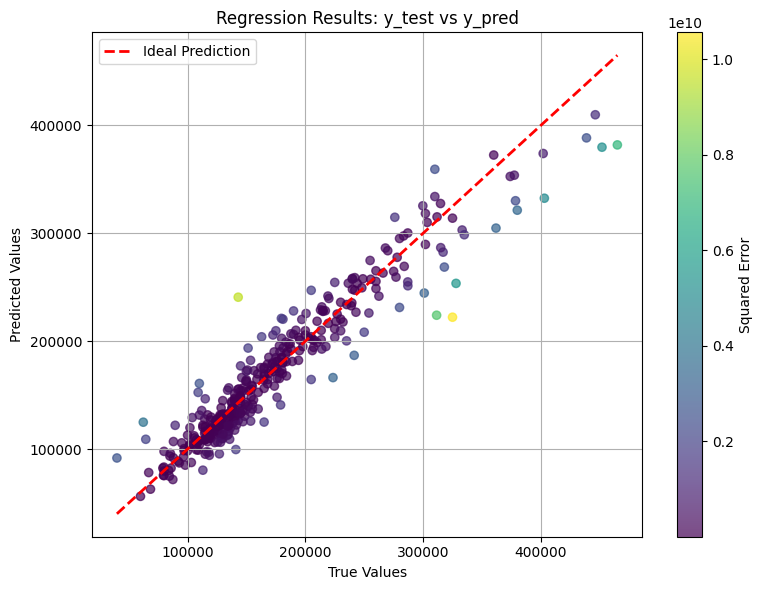

RMSE = 22023.8108548007
Train RMSE: 25690.6148
Test  RMSE: 22023.7046


In [21]:
# clf = Lasso(alpha=0.0001, max_iter=500,  random_state=42, selection='cyclic')
clf = Ridge(alpha = 0.001, max_iter=2000)
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)
y_pred = np.expm1(y_pred)

squared_errors = ((y_pred - y_test_exp)**2)
mse = mean_squared_error(y_test_exp,y_pred)

plt.figure(figsize=(8, 6))
sc = plt.scatter(y_test_exp, y_pred, c=squared_errors, cmap="viridis", alpha=0.7)
plt.plot([y_test_exp.min(), y_test_exp.max()], [y_test_exp.min(), y_test_exp.max()], 'r--', lw=2, label="Ideal Prediction")
plt.colorbar(sc, label="Squared Error")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Regression Results: y_test vs y_pred")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.yscale('log')
# plt.xscale('log') 
plt.show()


train_preds = clf.predict(X_train_scaled)
test_preds  = clf.predict(X_test_scaled)

train_rmse = mean_squared_error(np.exp(y_train), np.exp(train_preds))
test_rmse  = mean_squared_error(y_test_exp, np.exp(test_preds))
print('RMSE = {}'.format(np.sqrt(mse)))
print(f"Train RMSE: {np.sqrt(train_rmse):.4f}")
print(f"Test  RMSE: {np.sqrt(test_rmse):.4f}")


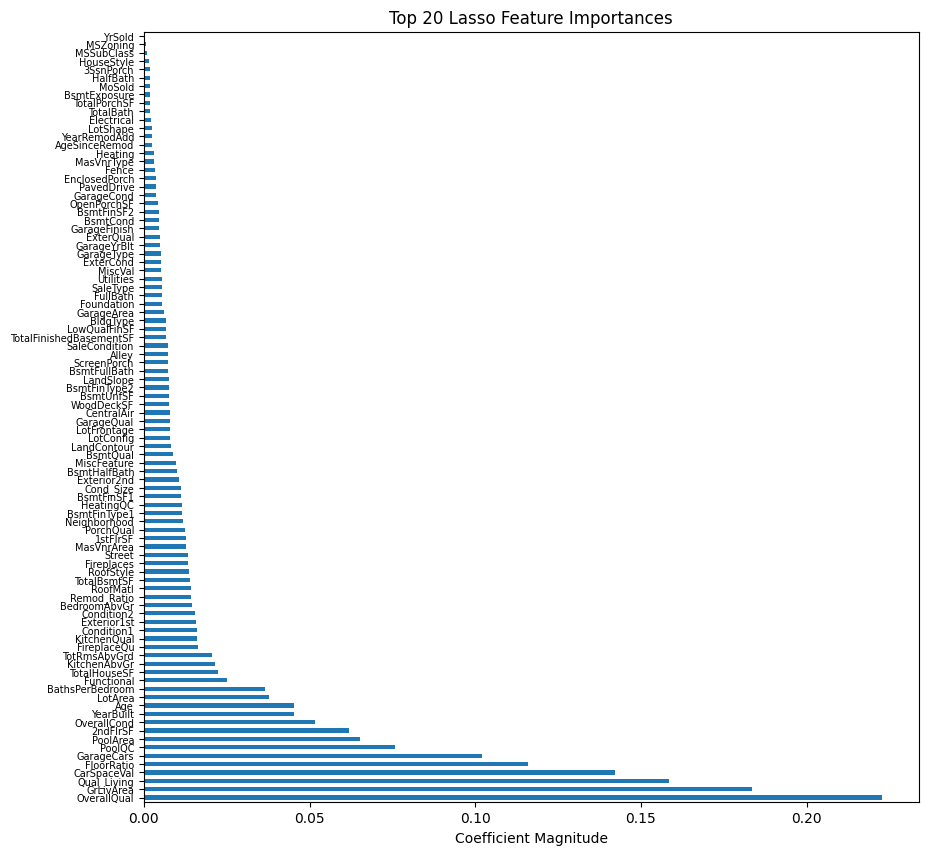

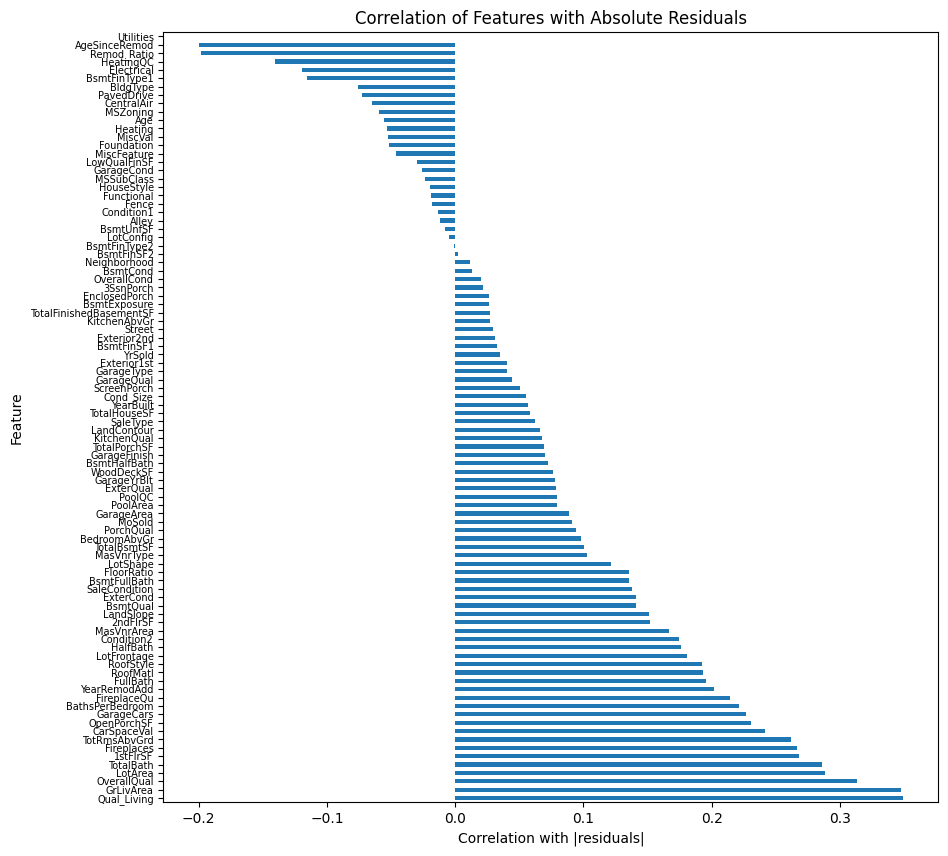

In [22]:
import matplotlib.pyplot as plt
# assuming clf is your trained Lasso
coef = pd.Series(clf.coef_, index=X.columns)
top_features = coef.abs().sort_values(ascending=False)

plt.figure(figsize=(10,10))
top_features.plot(kind="barh")
plt.xlabel("Coefficient Magnitude")
plt.yticks(fontsize = 7, rotation = 0)
plt.title("Top 20 Lasso Feature Importances")
plt.show()

residuals = y_test_exp - y_pred
# absolute error
abs_residuals = np.abs(residuals)

# put back into a dataframe
res_df = X_test.copy()
res_df["abs_residuals"] = abs_residuals

# correlate features with residuals
correlations = res_df.corr()["abs_residuals"].sort_values(ascending=False)
# exclude the trivial "abs_residuals" correlation with itself (=1)
corr_plot = correlations.drop("abs_residuals")

plt.figure(figsize=(10,10))
corr_plot.plot(kind="barh")
plt.title("Correlation of Features with Absolute Residuals")
plt.xlabel("Correlation with |residuals|")
plt.yticks(fontsize = 7, rotation = 0)
plt.ylabel("Feature")
plt.show()


*** Let's try using XGBOOST ***

In [238]:
# ### Fine tune parmters in bulk using RandomizedSearchCV
# import xgboost as xgb
# from sklearn.model_selection import RandomizedSearchCV

# param_dist = {
#     "max_depth": [3, 4, 5, 6],
#     "learning_rate": [0.01, 0.05, 0.1],
#     "n_estimators": [300, 500, 1000],
#     "subsample": [0.6, 0.8, 1.0],
#     "colsample_bytree": [0.6, 0.8, 1.0],
#     "reg_alpha": [0, 0.5, 1],
#     "reg_lambda": [0.5, 1, 2],
# }

# xgb_model = xgb.XGBRegressor(
#     tree_method='gpu_hist',
#     predictor='gpu_predictor',
#     random_state=42
# )

# random_search = RandomizedSearchCV(
#     estimator=xgb_model,
#     param_distributions=param_dist,
#     n_iter=10,   
#     scoring="neg_root_mean_squared_error",
#     cv=5,
#     verbose=2,
#     n_jobs=-1,
#     random_state=42
# )


# random_search.fit(X_train, y_train)

# print("Best parameters:", random_search.best_params_)
# print("Best CV RMSE:", -random_search.best_score_)

## Add CosineAnnealingLR
$$
\eta(t) = \eta_{min} + \frac{1}{2}(\eta_{max} - \eta_{min}) \left(1 + \cos\left(\frac{t \pi}{T}\right)\right)
$$

[0]	validation_0-rmse:0.38038	validation_1-rmse:0.37741
[1]	validation_0-rmse:0.36768	validation_1-rmse:0.36435
[2]	validation_0-rmse:0.35604	validation_1-rmse:0.35297
[3]	validation_0-rmse:0.34490	validation_1-rmse:0.34183
[4]	validation_0-rmse:0.33412	validation_1-rmse:0.33074
[5]	validation_0-rmse:0.32400	validation_1-rmse:0.32027
[6]	validation_0-rmse:0.31428	validation_1-rmse:0.31036
[7]	validation_0-rmse:0.30547	validation_1-rmse:0.30150
[8]	validation_0-rmse:0.29700	validation_1-rmse:0.29285
[9]	validation_0-rmse:0.28945	validation_1-rmse:0.28509
[10]	validation_0-rmse:0.28182	validation_1-rmse:0.27725
[11]	validation_0-rmse:0.27449	validation_1-rmse:0.27003
[12]	validation_0-rmse:0.26744	validation_1-rmse:0.26301
[13]	validation_0-rmse:0.26120	validation_1-rmse:0.25616
[14]	validation_0-rmse:0.25563	validation_1-rmse:0.25028
[15]	validation_0-rmse:0.25007	validation_1-rmse:0.24481
[16]	validation_0-rmse:0.24467	validation_1-rmse:0.23945
[17]	validation_0-rmse:0.23911	validation

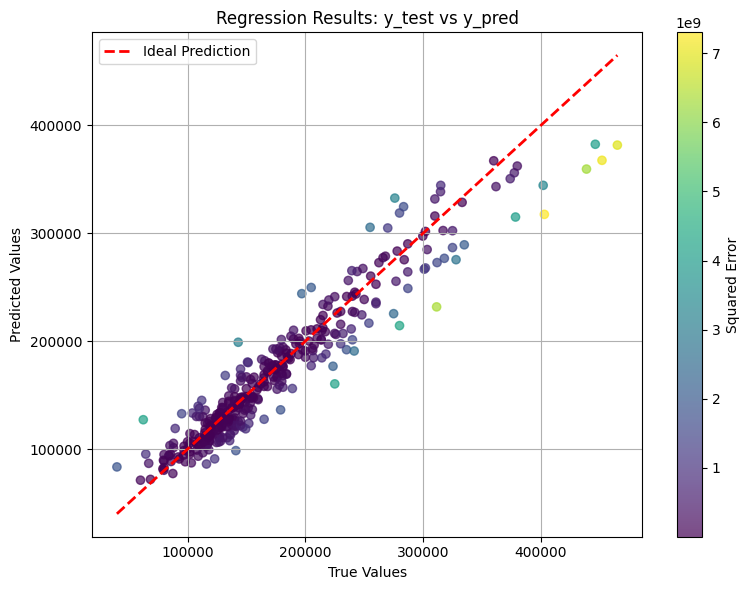

RMSE = 21810.574749472747
Train RMSE: 21795.9721
Test  RMSE: 21810.3889


In [23]:

# random_search.best_params_
import xgboost as xgb
dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
dtest  = xgb.DMatrix(X_test_scaled, label=y_test)

n_estimators = 1000
eta_max = 0.05
eta_min = 0.001
def CosineAnnealingLR(t, eta_max =eta_max,  eta_min = eta_min, T = n_estimators):
    factor = 1 + np.cos(t*np.pi/T)
    return eta_min + 0.5*(eta_max - eta_min)*factor

xgb_model = xgb.XGBRegressor(
    subsample= 0.8,    
    n_estimators= n_estimators,
    max_depth= 4,
    learning_rate= eta_max,
    colsample_bytree= 0.8,
    reg_lambda= 2,
    reg_alpha= 4, 
    tree_method="hist",
    device="cuda",
    callbacks=[xgb.callback.LearningRateScheduler(CosineAnnealingLR)],
    random_state=42)
    

xgb_model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_train_scaled, y_train), (X_test_scaled, y_test)],
    verbose=True,
)

y_pred = xgb_model.predict(X_test_scaled)
y_pred = np.expm1(y_pred)

squared_errors = ((y_pred - y_test_exp)**2)
mse = mean_squared_error(y_test_exp,y_pred)

plt.figure(figsize=(8, 6))
sc = plt.scatter(y_test_exp, y_pred, c=squared_errors, cmap="viridis", alpha=0.7)
plt.plot([y_test_exp.min(), y_test_exp.max()], [y_test_exp.min(), y_test_exp.max()], 'r--', lw=2, label="Ideal Prediction")
plt.colorbar(sc, label="Squared Error")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Regression Results: y_test vs y_pred")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.yscale('log')
# plt.xscale('log')
plt.show()


train_preds = xgb_model.predict(X_train_scaled)
test_preds  = xgb_model.predict(X_test_scaled)

train_rmse = mean_squared_error(np.exp(y_train), np.exp(train_preds))
test_rmse  = mean_squared_error(y_test_exp, np.exp(test_preds))
print('RMSE = {}'.format(np.sqrt(mse)))
print(f"Train RMSE: {np.sqrt(train_rmse):.4f}")
print(f"Test  RMSE: {np.sqrt(test_rmse):.4f}")



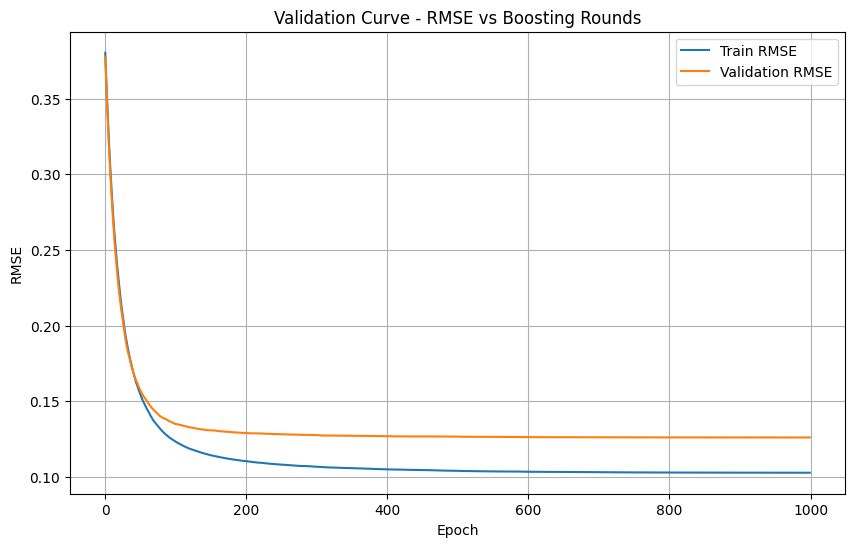

In [24]:
results = xgb_model.evals_result()

train_rmse = results['validation_0']['rmse']
test_rmse  = results['validation_1']['rmse']

plt.figure(figsize=(10,6))
plt.plot(train_rmse, label="Train RMSE")
plt.plot(test_rmse, label="Validation RMSE")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Validation Curve - RMSE vs Boosting Rounds")
plt.legend()
plt.grid()
plt.show()

In [41]:
# Now we get the testign data nad prep it for validation: 
test_data = test_df[features]

# lets remove all NaNs for now
test_data = test_data.dropna()
testing_data = scaler.transform(test_data)

# now we see the first predition: 
predicted = xgb_model.predict(testing_data)

#prediction submission: 
sub = {'Id':test_df[features + ["Id"]].dropna()["Id"] , 'SalePrice': np.expm1(predicted)}
sub = pd.DataFrame(sub)
sub.to_csv('../submissions/sub_house_prices_v1.csv', index = False)
sub

ValueError: Input X contains infinity or a value too large for dtype('float64').

In [246]:
print(X_train.shape)
print(X_train.describe())
print(X_train.isna().sum())



(1095, 79)
        MSSubClass     MSZoning  LotFrontage      LotArea       Street  \
count  1095.000000  1095.000000  1095.000000  1095.000000  1095.000000   
mean     57.118721     1.336986     4.219566     9.122014     1.003653   
std      42.624531     0.801422     0.327406     0.525610     0.060357   
min      20.000000     1.000000     3.091042     7.170888     1.000000   
25%      20.000000     1.000000     4.110874     8.934587     1.000000   
50%      50.000000     1.000000     4.262680     9.169623     1.000000   
75%      70.000000     1.000000     4.394449     9.367430     1.000000   
max     190.000000     5.000000     5.749393    12.279537     2.000000   

             Alley     LotShape  LandContour    Utilities    LotConfig  ...  \
count  1095.000000  1095.000000  1095.000000  1095.000000  1095.000000  ...   
mean      0.087671     1.424658     1.176256     1.000913     1.645662  ...   
std       0.357198     0.593640     0.606924     0.030220     1.040548  ...   
min   

In [10]:
import lightgbm as lgb
from sklearn.linear_model import Ridge
import xgboost as xgb
dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
dtest  = xgb.DMatrix(X_test_scaled, label=y_test)

n_estimators = 2000

lgbm_model = lgb.LGBMRegressor(
    n_estimators=n_estimators,
    max_depth=4,
    learning_rate=0.5,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_alpha=1,
    reg_lambda=3,
    random_state=42
)

print('Training LIGHTGbm')
lgbm_model.fit(X_train_scaled, y_train, eval_set=[(X_test_scaled, y_test)])

print('Fitting Ridge')
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_scaled, y_train)


xgb_model = xgb.XGBRegressor(
    subsample= 0.8,    
    n_estimators= n_estimators,
    max_depth= 4,
    learning_rate= 0.1,
    colsample_bytree= 0.6,
    reg_lambda= 2,
    reg_alpha= 0, 
    tree_method="hist",
    device="cuda",
    early_stopping_rounds = 100,
    random_state=42)
    # callbacks=[xgb.callback.LearningRateScheduler(CosineAnnealingLR)],

print('Training XgBoost')
xgb_model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_train_scaled, y_train), (X_test_scaled, y_test)],
    verbose=True,
)

Training LIGHTGbm
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2853
[LightGBM] [Info] Number of data points in the train set: 1092, number of used features: 31
[LightGBM] [Info] Start training from score 12.029181
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.6
,device,'cuda'
,early_stopping_rounds,100
,enable_categorical,False
,eval_metric,None


/home/federicostachurski/kaggle-projects/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Ensemble Test RMSE: 25802.7168


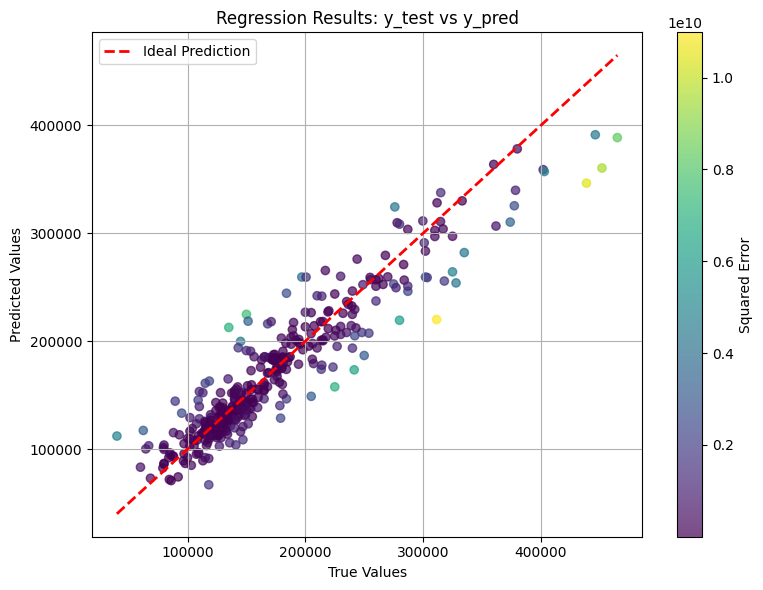

In [11]:
# predictions on test set 
def stacking_predictor(X_test_scaled, w_lgbm = 0.2, w_ridge = 0.2, w_xgb = 0.6):
    lgbm_preds = lgbm_model.predict(X_test_scaled)
    ridge_preds = ridge_model.predict(X_test_scaled)
    xgb_preds = xgb_model.predict(X_test_scaled)

    lgbm_preds_exp = np.expm1(lgbm_preds)
    ridge_preds_exp = np.expm1(ridge_preds)
    xgb_preds_exp = np.expm1(xgb_preds)
    ensemble_preds = (w_lgbm * lgbm_preds_exp + 
                    w_ridge * ridge_preds_exp + 
                    w_xgb * xgb_preds_exp)
    return ensemble_preds

ensemble_preds = stacking_predictor(X_test_scaled)
mse_ensemble = mean_squared_error(np.expm1(y_test), ensemble_preds)
rmse_ensemble = np.sqrt(mse_ensemble)

print(f"Ensemble Test RMSE: {rmse_ensemble:.4f}")


plt.figure(figsize=(8, 6))
sc = plt.scatter(np.expm1(y_test), ensemble_preds, c=squared_errors, cmap="viridis", alpha=0.7)
plt.plot([np.expm1(y_test).min(), np.expm1(y_test).max()], [np.expm1(y_test).min(), np.expm1(y_test).max()], 'r--', lw=2, label="Ideal Prediction")
plt.colorbar(sc, label="Squared Error")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Regression Results: y_test vs y_pred")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.yscale('log')
# plt.xscale('log')
plt.show()

In [92]:
# Now we get the testign data nad prep it for validation: 
test_data = test_df[features]

# lets remove all NaNs for now
# test_data = test_data.dropna()
test_data = test_data[features]
testing_data = scaler.transform(test_data)

# now we see the first predition: 
# predicted = xgb_model.predict(testing_data)
predicted = stacking_predictor(testing_data)

#prediction submission: 
sub = {'Id':test_df[features + ["Id"]].dropna()["Id"] , 'SalePrice': np.expm1(predicted)}
sub = pd.DataFrame(sub)
# sub.to_csv('../submissions/sub_house_prices_v1.csv', index = False)
sub

ValueError: Input X contains infinity or a value too large for dtype('float64').